In [1]:
# Standard library
import math
import pickle
from collections import defaultdict
from pathlib import Path

# Third-party
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from simpy import Environment

# Simulador - Core
from simulador import analysis
from simulador.main import Simulator
from simulador import Scenario, ScenarioGenerator, Metrics
from simulador.config.settings import NUMERO_DE_REQUISICOES, NUMERO_DE_SLOTS
from simulador import routing

# Simulador - Analysis
from simulador import analysis, visualization

# Simulador - Visualization
from simulador.visualization import (
    availability_plots,
    traffic_plots,
)

# Jupyter configuration
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Load topology
TOPOLOGY = nx.read_weighted_edgelist("topology/usa", nodetype=int)

print("✓ All modules loaded successfully!")


✓ All modules loaded successfully!


In [2]:
with open("output/cenario_disaster_aware.pkl", "rb") as file:
    cenario_base = pickle.load(file)

In [3]:
list_of_weights = [ (i/10, j/10, k/10) for i in range(1, 6) for j in range(1, 6) for k in range(1, 6) ]

In [4]:
# Generate scenarios with different weights
# Note: Generation is fast (~1-2 min), caching would be slower due to large file size
print("🔧 Generating scenarios with different weights...")
print("   (This is fast - just deep copying and recomputing paths)")

scenarios = ScenarioGenerator.gerar_cenarios_com_diferentes_pesos(cenario_base, list_of_weights)

print(f"✓ Generated {len(scenarios)} scenarios")
print(f"✓ Ready to run experiments")

# Optional: If you still want to cache (NOT RECOMMENDED - very slow and large file)
# scenarios_cache_path = Path("output/best_weight_experiment/generated_scenarios.pkl")
# with open(scenarios_cache_path, "wb") as f:
#     pickle.dump(scenarios, f)


🔧 Generating scenarios with different weights...
   (This is fast - just deep copying and recomputing paths)
Creating scenario variant 1/125 with α=0.10, β=0.10, γ=0.10
Creating scenario variant 2/125 with α=0.10, β=0.10, γ=0.20
Creating scenario variant 3/125 with α=0.10, β=0.10, γ=0.30
Creating scenario variant 4/125 with α=0.10, β=0.10, γ=0.40
Creating scenario variant 5/125 with α=0.10, β=0.10, γ=0.50
Creating scenario variant 6/125 with α=0.10, β=0.20, γ=0.10
Creating scenario variant 7/125 with α=0.10, β=0.20, γ=0.20
Creating scenario variant 8/125 with α=0.10, β=0.20, γ=0.30
Creating scenario variant 9/125 with α=0.10, β=0.20, γ=0.40
Creating scenario variant 10/125 with α=0.10, β=0.20, γ=0.50
Creating scenario variant 11/125 with α=0.10, β=0.30, γ=0.10
Creating scenario variant 12/125 with α=0.10, β=0.30, γ=0.20
Creating scenario variant 13/125 with α=0.10, β=0.30, γ=0.30
Creating scenario variant 14/125 with α=0.10, β=0.30, γ=0.40
Creating scenario variant 15/125 with α=0.10, 

### Why No Caching?

**Caching scenarios is actually counterproductive:**
- **File size**: 500MB-2GB (125 scenarios with full topology, ISPs, and requests)
- **Pickle time**: Several minutes to serialize
- **Load time**: Several minutes to deserialize
- **Generation time**: Only 1-2 minutes (fast deep copy + path recomputation)

**Verdict**: Regenerating is faster and uses less disk space! ⚡


In [5]:
# # Uncomment the lines below to force regenerate scenarios
# 
# print("🗑️  Deleting cached scenarios...")
# if scenarios_cache_path.exists():
#     scenarios_cache_path.unlink()
#     print("✓ Cache deleted")
# 
# print("🔧 Regenerating scenarios with different weights...")
# scenarios = ScenarioGenerator.gerar_cenarios_com_diferentes_pesos(cenario_base, list_of_weights)
# 
# print(f"💾 Saving {len(scenarios)} scenarios to cache...")
# scenarios_cache_path.parent.mkdir(parents=True, exist_ok=True)
# with open(scenarios_cache_path, "wb") as f:
#     pickle.dump(scenarios, f)
# print(f"✓ Scenarios regenerated and cached to: {scenarios_cache_path}")

print("ℹ️  Uncomment code above to force regenerate scenarios")


ℹ️  Uncomment code above to force regenerate scenarios


## Run Experiments in Parallel

Now we'll run all scenarios in parallel using **multiprocessing** (not threading) for true parallel execution:

### Why Multiprocessing?
- **Python GIL limitation**: Threading doesn't provide true parallelism for CPU-bound tasks
- **SimPy simulations are CPU-intensive**: Event processing, routing calculations
- **ProcessPoolExecutor**: Spawns separate Python processes, bypassing the GIL
- **Expected speedup**: ~8x with 8 CPU cores (vs. sequential execution)

### ⚠️ Why Worker Function is in a Separate File

The worker function is imported from `experiment_worker.py` instead of being defined in this notebook because:
- **macOS uses `spawn` multiprocessing**: Each worker starts with a fresh Python interpreter
- **Jupyter notebooks can't be imported**: Functions defined in cells exist only in the `__main__` namespace
- **Pickling fails**: When `ProcessPoolExecutor` tries to send the function to workers, it can't find it
- **Solution**: External `.py` module can be imported by all worker processes ✓

### Expected Time
- **Per scenario**: ~2 minutes
- **125 scenarios total**: 
  - Sequential: ~250 minutes (4+ hours)
  - Parallel (8 cores): ~32 minutes ⚡
  
Results will be saved to organized directories for each weight configuration.


In [6]:
import os
from pathlib import Path
from concurrent.futures import ProcessPoolExecutor, as_completed
from datetime import datetime

# Create base output directory
BASE_OUTPUT_DIR = Path("output/best_weight_experiment")
BASE_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"✓ Output directory created: {BASE_OUTPUT_DIR}")
print(f"✓ Total scenarios to run: {len(scenarios)}")
print(f"✓ Available CPU cores: {os.cpu_count()}")


✓ Output directory created: output/best_weight_experiment
✓ Total scenarios to run: 125
✓ Available CPU cores: 10


In [7]:
# Import worker function from separate module (required for multiprocessing)
from experiment_worker import run_scenario_experiment

print("✓ Worker function imported from experiment_worker.py")


✓ Worker function imported from experiment_worker.py


In [8]:
# Run all scenarios in parallel using multiprocessing
print(f"Starting parallel execution of {len(scenarios)} scenarios...")
print(f"Start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("-" * 80)

# Track results
results = []
start_time = datetime.now()

# Use ProcessPoolExecutor for TRUE parallel execution (bypasses Python GIL)
# Adjust max_workers based on your CPU cores
max_workers = min(os.cpu_count() or 4, 8)  # Use up to 8 parallel workers
print(f"Using {max_workers} parallel processes")
print("-" * 80)

# Prepare arguments for each scenario
scenario_args = [
    (scenario, idx, len(scenarios), str(BASE_OUTPUT_DIR))
    for idx, scenario in enumerate(scenarios)
]

# Run scenarios in parallel
with ProcessPoolExecutor(max_workers=max_workers) as executor:
    # Submit all scenarios
    futures = [executor.submit(run_scenario_experiment, args) for args in scenario_args]
    
    # Process completed scenarios as they finish
    for future in as_completed(futures):
        result = future.result()
        results.append(result)

# Calculate statistics
end_time = datetime.now()
duration = end_time - start_time
successful = sum(1 for r in results if r[0])
failed = len(results) - successful

print("-" * 80)
print(f"\n{'='*80}")
print(f"EXPERIMENT COMPLETED")
print(f"{'='*80}")
print(f"Total scenarios: {len(scenarios)}")
print(f"Successful: {successful}")
print(f"Failed: {failed}")
print(f"Duration: {duration}")
print(f"Average time per scenario: {duration / len(scenarios)}")
print(f"Speedup vs sequential: {len(scenarios) * 2 / (duration.total_seconds() / 60):.2f}x")
print(f"End time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"\nResults saved to: {BASE_OUTPUT_DIR}")
print(f"{'='*80}")


Starting parallel execution of 125 scenarios...
Start time: 2025-11-08 18:41:56
--------------------------------------------------------------------------------
Using 8 parallel processes
--------------------------------------------------------------------------------
[1/125] Starting: α=0.1, β=0.1, γ=0.1
[2/125] Starting: α=0.1, β=0.1, γ=0.2
[3/125] Starting: α=0.1, β=0.1, γ=0.3
[4/125] Starting: α=0.1, β=0.1, γ=0.4
[5/125] Starting: α=0.1, β=0.1, γ=0.5
[6/125] Starting: α=0.1, β=0.2, γ=0.1
[7/125] Starting: α=0.1, β=0.2, γ=0.2
[8/125] Starting: α=0.1, β=0.2, γ=0.3
[1/125] ✓ Completed: α=0.1, β=0.1, γ=0.1
[9/125] Starting: α=0.1, β=0.2, γ=0.4
[2/125] ✓ Completed: α=0.1, β=0.1, γ=0.2
[3/125] ✓ Completed: α=0.1, β=0.1, γ=0.3
[4/125] ✓ Completed: α=0.1, β=0.1, γ=0.4
[10/125] Starting: α=0.1, β=0.2, γ=0.5
[5/125] ✓ Completed: α=0.1, β=0.1, γ=0.5
[11/125] Starting: α=0.1, β=0.3, γ=0.1
[6/125] ✓ Completed: α=0.1, β=0.2, γ=0.1
[12/125] Starting: α=0.1, β=0.3, γ=0.2
[7/125] ✓ Completed: α=0.1

In [15]:
# Create a summary CSV of all experiments
summary_data = []

for success, alpha, beta, gamma, output_dir in results:
    if success:
        # Read the dataframe to get summary statistics
        df_path = Path(output_dir) / f"dataframe_{alpha:.1f}_{beta:.1f}_{gamma:.1f}.csv"
        try:
            df = pd.read_csv(df_path, low_memory=False)
            
            # Calculate summary metrics (overall)
            total_requests = len(df)
            blocked_requests = df['bloqueada'].sum()
            blocking_rate = blocked_requests / total_requests if total_requests > 0 else 0
            availability = 1 - blocking_rate
            
            # Calculate migration-specific metrics
            migration_df = df[df['requisicao_de_migracao'] == True]
            migration_total = len(migration_df)
            migration_blocked = migration_df['bloqueada'].sum() if migration_total > 0 else 0
            migration_blocking_rate = migration_blocked / migration_total if migration_total > 0 else 0
            migration_availability = 1 - migration_blocking_rate if migration_total > 0 else 0
            
            summary_data.append({
                'alpha': alpha,
                'beta': beta,
                'gamma': gamma,
                'total_requests': total_requests,
                'blocked_requests': int(blocked_requests),
                'blocking_rate': blocking_rate,
                'availability': availability,
                'migration_total': migration_total,
                'migration_blocked': int(migration_blocked),
                'migration_blocking_rate': migration_blocking_rate,
                'migration_availability': migration_availability,
                'output_dir': output_dir,
                'success': True
            })
        except Exception as e:
            print(f"Warning: Could not read results for α={alpha:.1f}, β={beta:.1f}, γ={gamma:.1f}: {e}")
            summary_data.append({
                'alpha': alpha,
                'beta': beta,
                'gamma': gamma,
                'total_requests': 0,
                'blocked_requests': 0,
                'blocking_rate': 0,
                'availability': 0,
                'migration_total': 0,
                'migration_blocked': 0,
                'migration_blocking_rate': 0,
                'migration_availability': 0,
                'output_dir': output_dir,
                'success': False
            })
    else:
        summary_data.append({
            'alpha': alpha,
            'beta': beta,
            'gamma': gamma,
            'total_requests': 0,
            'blocked_requests': 0,
            'blocking_rate': 0,
            'availability': 0,
            'migration_total': 0,
            'migration_blocked': 0,
            'migration_blocking_rate': 0,
            'migration_availability': 0,
            'output_dir': output_dir,
            'success': False
        })

# Create summary dataframe
summary_df = pd.DataFrame(summary_data)

# Save summary
summary_path = BASE_OUTPUT_DIR / "experiment_summary.csv"
summary_df.to_csv(summary_path, index=False)

print(f"✓ Summary saved to: {summary_path}")
print(f"\nTop 10 configurations by availability:")
print(summary_df.nlargest(10, 'availability')[['alpha', 'beta', 'gamma', 'availability', 'migration_availability']])
print(f"\nTop 10 configurations by migration availability:")
print(summary_df.nlargest(10, 'migration_availability')[['alpha', 'beta', 'gamma', 'availability', 'migration_availability']])


✓ Summary saved to: output/best_weight_experiment/experiment_summary.csv

Top 10 configurations by availability:
    alpha  beta  gamma  availability  migration_availability
10    0.1   0.3    0.1      0.676546                0.539729
15    0.1   0.4    0.1      0.676546                0.539729
16    0.1   0.4    0.2      0.676546                0.539729
20    0.1   0.5    0.1      0.676546                0.539729
21    0.1   0.5    0.2      0.676546                0.539729
22    0.1   0.5    0.3      0.676546                0.539729
23    0.1   0.5    0.4      0.676546                0.539729
0     0.1   0.1    0.1      0.676539                0.541253
1     0.1   0.1    0.2      0.676539                0.541253
2     0.1   0.1    0.3      0.676539                0.541253

Top 10 configurations by migration availability:
    alpha  beta  gamma  availability  migration_availability
30    0.2   0.2    0.1      0.675991                0.543623
32    0.2   0.2    0.3      0.675991        

In [16]:
print(f"\nTop 10 worstconfigurations by availability:")

print(summary_df.nsmallest(10, 'availability')[['alpha', 'beta', 'gamma', 'availability', 'migration_availability']])

print(f"\nTop 10 worstconfigurations by migration availability:")

print(summary_df.nsmallest(10, 'availability')[['alpha', 'beta', 'gamma', 'availability', 'migration_availability']])



Top 10 worstconfigurations by availability:
    alpha  beta  gamma  availability  migration_availability
30    0.2   0.2    0.1      0.675991                0.543623
32    0.2   0.2    0.3      0.675991                0.543623
34    0.2   0.2    0.5      0.675991                0.543623
40    0.2   0.4    0.1      0.675991                0.543623
42    0.2   0.4    0.3      0.675991                0.543623
49    0.2   0.5    0.5      0.675991                0.543623
52    0.3   0.1    0.3      0.675991                0.543623
54    0.3   0.1    0.5      0.675991                0.543623
57    0.3   0.2    0.3      0.675991                0.543623
58    0.3   0.2    0.4      0.675991                0.543623

Top 10 worstconfigurations by migration availability:
    alpha  beta  gamma  availability  migration_availability
30    0.2   0.2    0.1      0.675991                0.543623
32    0.2   0.2    0.3      0.675991                0.543623
34    0.2   0.2    0.5      0.675991          

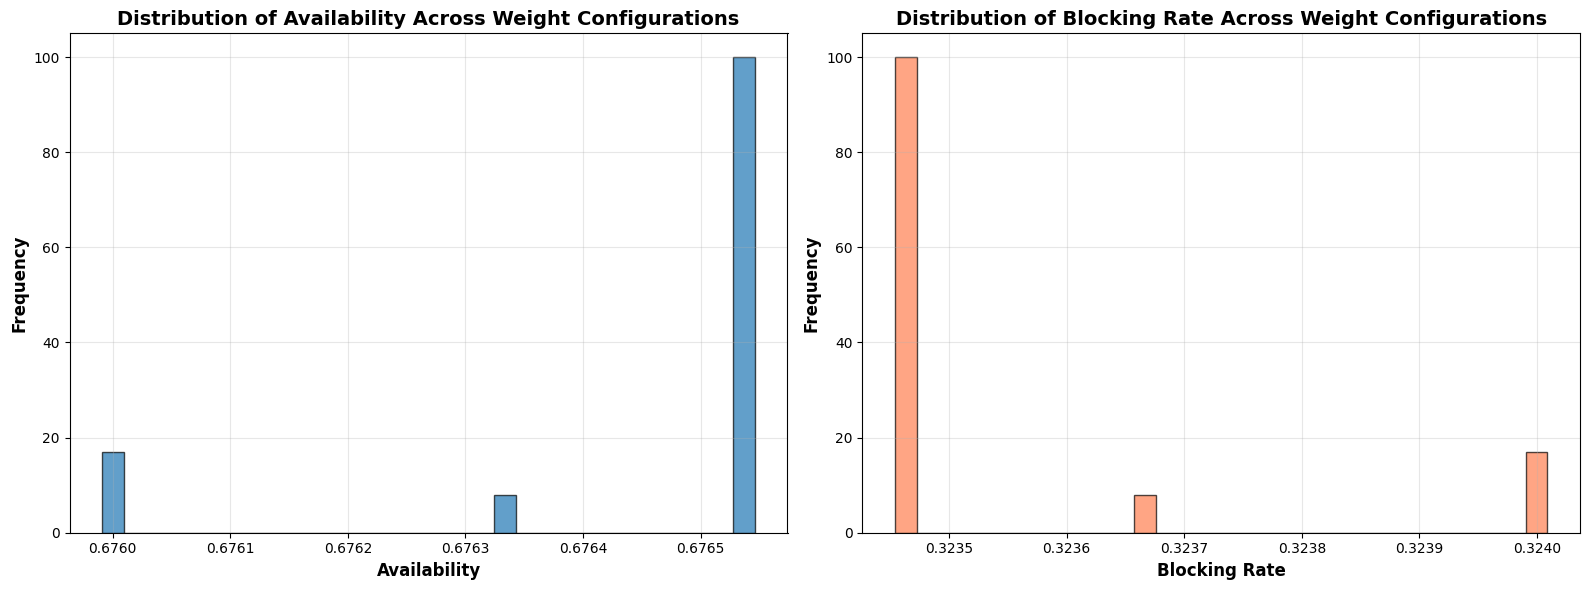


✓ Visualization saved to: output/best_weight_experiment/results_distribution.png


In [10]:
# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Availability distribution
successful_results = summary_df[summary_df['success'] == True]
axes[0].hist(successful_results['availability'], bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Availability', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0].set_title('Distribution of Availability Across Weight Configurations', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# Plot 2: Blocking rate distribution
axes[1].hist(successful_results['blocking_rate'], bins=30, edgecolor='black', alpha=0.7, color='coral')
axes[1].set_xlabel('Blocking Rate', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1].set_title('Distribution of Blocking Rate Across Weight Configurations', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(BASE_OUTPUT_DIR / 'results_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Visualization saved to: {BASE_OUTPUT_DIR / 'results_distribution.png'}")


## Results Analysis

The experiment results are organized as follows:

### Directory Structure
```
output/best_weight_experiment/
├── 0.1_0.1_0.1/
│   ├── scenario_0.1_0.1_0.1.pkl
│   └── dataframe_0.1_0.1_0.1.csv
├── 0.1_0.1_0.2/
│   ├── scenario_0.1_0.1_0.2.pkl
│   └── dataframe_0.1_0.1_0.2.csv
├── ...
├── experiment_summary.csv
└── results_distribution.png
```

### Files
- **`scenario_{α}_{β}_{γ}.pkl`**: Scenario object with specific weight configuration
- **`dataframe_{α}_{β}_{γ}.csv`**: Complete simulation results (all requests)
- **`experiment_summary.csv`**: Summary of all experiments with key metrics
- **`results_distribution.png`**: Distribution visualization

### Finding the Best Configuration
Use `experiment_summary.csv` to identify optimal weight configurations based on:
- **Highest Availability**: Best overall network performance
- **Lowest Blocking Rate**: Fewest rejected requests
- **Trade-offs**: Balance between different objectives


In [11]:
# Example: Load and analyze a specific configuration
# Uncomment and modify to analyze specific results

# # Load the best configuration
# best_config = summary_df.nlargest(1, 'availability').iloc[0]
# alpha_best = best_config['alpha']
# beta_best = best_config['beta']
# gamma_best = best_config['gamma']
# 
# print(f"Best configuration: α={alpha_best:.1f}, β={beta_best:.1f}, γ={gamma_best:.1f}")
# print(f"Availability: {best_config['availability']:.4f}")
# print(f"Blocking Rate: {best_config['blocking_rate']:.4f}")
# 
# # Load the detailed dataframe
# best_df_path = Path(best_config['output_dir']) / f"dataframe_{alpha_best:.1f}_{beta_best:.1f}_{gamma_best:.1f}.csv"
# best_df = pd.read_csv(best_df_path, low_memory=False)
# 
# # Analyze further...
# print(f"\nDetailed statistics:")
# print(f"Total requests: {len(best_df)}")
# print(f"Blocked requests: {best_df['bloqueada'].sum()}")
# print(f"Migration requests: {best_df['requisicao_de_migracao'].sum()}")

print("✓ Example code ready (uncomment to use)")


✓ Example code ready (uncomment to use)
